In [2]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from copy import deepcopy

from src.data.dataset import ChestXRayDataset, get_transforms
from src.models.baseline import get_model
from src.explainability.gradcam import GradCAM
from src.explainability.visualizations import denormalize_image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print(f"Project root: {project_root}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Project root: /home/javier/final_project_xai


In [22]:
checkpoint_dir = project_root / 'models' / 'checkpoints'

print("Loading baseline model...")
baseline_model = get_model(num_classes=2, pretrained=True, device=device)
baseline_checkpoint = torch.load(checkpoint_dir / 'baseline_best.pth', weights_only=False)
baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])
baseline_model.eval()

# Load test data
clean_data_dir = project_root / 'data' / 'raw' / 'chest_xray'
test_dataset = ChestXRayDataset(
    data_dir=str(clean_data_dir),
    split='test',
    split_file=None,
    transform=get_transforms('test')
)

# Get a random PNEUMONIA sample
pneumonia_idx = None
idx = random.randint(0, len(test_dataset) - 1)
while pneumonia_idx is None:
    image, label = test_dataset[idx]
    if label == 1:  # PNEUMONIA class
        pneumonia_idx = idx
    else:
        idx = random.randint(0, len(test_dataset) - 1)

image_tensor = image.unsqueeze(0).to(device)

print(f"Loaded baseline model and sample image (idx: {pneumonia_idx})")

Loading baseline model...
BaselineModel created:
   Architecture: ResNet18
   Pretrained: True
   Output classes: 2
   Dropout: 0.3
   Trainable parameters: 11,177,538
   Total parameters: 11,177,538
Loaded 624 images for TEST split
   NORMAL: 234 (37.5%)
   PNEUMONIA: 390 (62.5%)
Loaded baseline model and sample image (idx: 234)



SANITY CHECK: MODEL PARAMETER RANDOMIZATION
Question: Do explanations change when model weights are randomized?
Expected: YES - explanations should become meaningless

Registered hooks on layer: backbone.layer4
Randomizing model parameters...
Registered hooks on layer: backbone.layer4

Original model: Pred=1, Confidence=100.00%
Random model:   Pred=1, Confidence=50.01%

Saved: /home/javier/final_project_xai/reports/figures/14_sanity_check_randomization.png


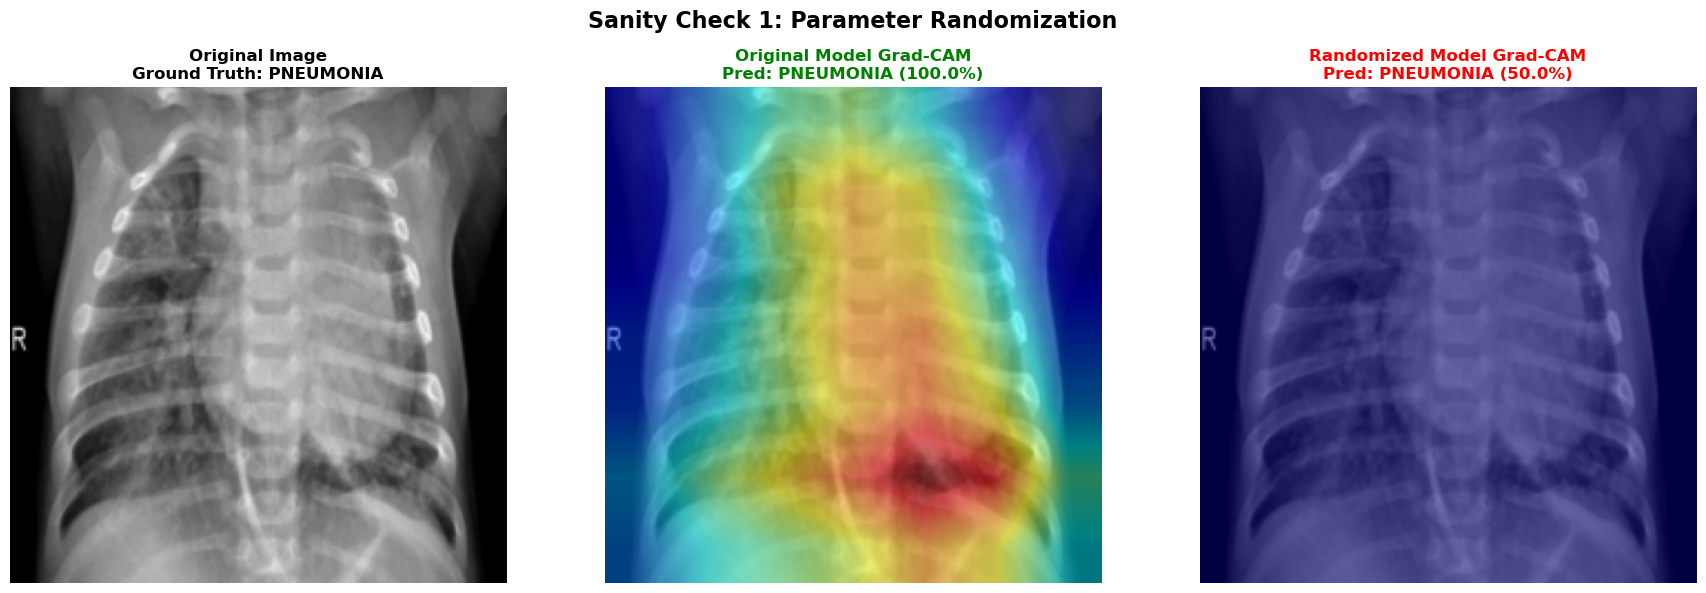

In [23]:
print("\n" + "="*70)
print("SANITY CHECK: MODEL PARAMETER RANDOMIZATION")
print("="*70)
print("Question: Do explanations change when model weights are randomized?")
print("Expected: YES - explanations should become meaningless\n")

# Original Grad-CAM
gradcam_original = GradCAM(baseline_model, 'backbone.layer4')
cam_original = gradcam_original(image_tensor, target_class=1)

print("Randomizing model parameters...")
randomized_model = deepcopy(baseline_model)

def randomize_weights(model):
    """Randomize all model parameters"""
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
            for param in module.parameters():
                if param.requires_grad:
                    param.data = torch.randn_like(param.data) * 0.01
    return model

randomized_model = randomize_weights(randomized_model)
randomized_model.eval()

gradcam_random = GradCAM(randomized_model, 'backbone.layer4')
cam_random = gradcam_random(image_tensor, target_class=1)

# Get predictions for comparison
with torch.no_grad():
    out_original = baseline_model(image_tensor)
    out_random = randomized_model(image_tensor)
    
    pred_original = out_original.argmax(dim=1).item()
    pred_random = out_random.argmax(dim=1).item()
    
    conf_original = torch.softmax(out_original, dim=1)[0].max().item()
    conf_random = torch.softmax(out_random, dim=1)[0].max().item()

print(f"\nOriginal model: Pred={pred_original}, Confidence={conf_original:.2%}")
print(f"Random model:   Pred={pred_random}, Confidence={conf_random:.2%}")

# Visualize comparison
image_denorm = denormalize_image(image)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(image_denorm)
axes[0].set_title('Original Image\nGround Truth: PNEUMONIA', 
                 fontsize=12, fontweight='bold')
axes[0].axis('off')

# Original model Grad-CAM
from src.explainability.gradcam import overlay_heatmap_on_image
original_overlay = overlay_heatmap_on_image(image_denorm, cam_original, alpha=0.5)
axes[1].imshow(original_overlay)
axes[1].set_title(f'Original Model Grad-CAM\nPred: {["NORMAL", "PNEUMONIA"][pred_original]} ({conf_original:.1%})', 
                 fontsize=12, color='green', fontweight='bold')
axes[1].axis('off')

# Randomized model Grad-CAM
random_overlay = overlay_heatmap_on_image(image_denorm, cam_random, alpha=0.5)
axes[2].imshow(random_overlay)
axes[2].set_title(f'Randomized Model Grad-CAM\nPred: {["NORMAL", "PNEUMONIA"][pred_random]} ({conf_random:.1%})', 
                 fontsize=12, color='red', fontweight='bold')
axes[2].axis('off')

plt.suptitle('Sanity Check 1: Parameter Randomization', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

save_path = project_root / 'reports' / 'figures' / '14_sanity_check_randomization.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()

Como primer test, randomizamos los parámetros del modelo. Teóricamente, al no tener el modelo ningún conocimiento aprendido, las salidas de Grad-CAM deberían diferir en gran medida respecto a las obtenidas con el modelo entrenado.

Analizando la imagen resultante, podemos observar que el modelo no presta atención a ninguna región concreta de la imagen, sino que la atención está distribuida de manera uniforme por toda la imagen. Adicionalmente, la confianza del modelo colapsa a un 50% (esencialmente, aleatorio en un problema binario). Todo ello indica que podemos fiarnos, en cierta medida, de las explicaciones generadas por Grad-CAM para nuestro modelo entrenado.